In [45]:
import esda
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import seaborn as sns
from copy import deepcopy
from scipy.spatial.distance import cdist
from scipy import stats
from math import log as ln
import pathlib

zipcode_file = pathlib.Path("/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/tl_2017_us_zcta510.zip")
# Check existence
if zipcode_file.exists():
    zipcode_gdf = gpd.read_file(f"zip://{zipcode_file}")
else:
    print("File not found! Make sure it's in the current directory.")

# path to the indexes data
data_indexes = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/indexes'

# path to the destinations data
data_destinations = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/destinations'

# path for the OpenStreetMap data
data_osm = '/Users/gaiapizzuti/Documents/unitn/Bike-Inequality/data/osm'

osm_types = {
    'building': ['building'],
    'commercial': ['shop', 'tourism', 'office'],
    'emergency': ['emergency'],
    'government': ['government', 'military'],
    'healthcare': ['healthcare'],
    'landuse': ['landuse'],
    'natural': ['natural'],
    'power': ['power', 'backup_generator'],
    'public': ['historic'],
    'sport': ['sport'],
    'transportation': ['aeroway', 'highway', 'railway', 'waterway'],
}

amenities = {
    'commercial': ['marketplace', 'restaurant', 'fast_food', 'cafe', 'bar', 'pub'],
    'education': ['kindergarten', 'school', 'college', 'university', 'language_school'],
    'emergency': ['police', 'fire_station'],
    'financial': ['atm', 'bank', 'bureau_de_change', 'microfinance', 'mobile_money_agent', 'money_transfer'],
    'governement': ['court_house', 'townhall', 'embassy', 'post_office'],
    'healthcare': ['doctors', 'dentist', 'clinic', 'toilets', 'hospital', 'pharmacy'],
    'power': ['fuel'],
    'public': ['place_of_worship', 'community_centre', 'library', 'toilets'],
    'transportation': ['ferry_terminal', 'bus_station']
}

leisures = {
    'sport': ['stadium', 'swimming pool', 'pitch', 'sport_centre'],
    'landuse': ['park'],
}

In [46]:
def plot_pois_and_indexes(gdf, city):
    """
    Plots the POIs and the index on a map.
    """
    # normalization poi_density
    max_density = gdf["poi_density"].max()
    gdf["poi_density"] = gdf["poi_density"] / max_density

    # plot the data
    _, axes = plt.subplots(1, 2, figsize=(15, 7))

    gdf.plot(column="poi_density", ax=axes[0], legend=True, cmap="plasma", vmin=0, vmax=1)
    axes[0].set_title("POI Density")

    min_race = gdf["race"].min()
    gdf.plot(column="race", ax=axes[1], legend=True, cmap="viridis", vmin=0, vmax=ln(9))
    axes[1].set_title("Normalized mixing Index")
    
    plt.suptitle(city)

    plt.show()

def get_scatterplot(gdf, city):
    """
    Plots the scatter plot for POI density and indexes.
    """
    # plot the scatter plot for poi density (x) and indexes (y)
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=gdf, x="poi_density", y="family", alpha=0.5, label="Family")
    sns.scatterplot(data=gdf, x="poi_density", y="nonfamily", alpha=0.5, label="Non Family")
    sns.scatterplot(data=gdf, x="poi_density", y="married", alpha=0.5, label="Married")
    sns.scatterplot(data=gdf, x="poi_density", y="household", alpha=0.5, label="Household")
    sns.scatterplot(data=gdf, x="poi_density", y="race", alpha=0.5, label="Race")
    plt.title("POI Density vs Indexes for" + city)
    plt.xlabel("POI Density")
    plt.ylabel("Indexes")
    plt.legend()
    plt.show()

def plot_distances(gdf, city):
    """
    Plot the spatial and regular Pearson correlation for different distances.
    """
    sns.lineplot(data=gdf, x='Distance', y='Spatial Pearson', label='Spatial Pearson Correlation')
    sns.lineplot(data=gdf, x='Distance', y='Regular Pearson', label='Regular Pearson Correlation')
    plt.legend()
    plt.xticks(np.arange(500, 7000, 250), rotation=45)
    plt.suptitle('Spatial Pearson Correlation vs Regular Pearson Correlation for ' + city)
    plt.xlabel("Distance (m)")
    plt.ylabel("Spatial Pearson Correlation")
    plt.xlabel("Distance (m)")
    plt.ylabel("Regular Pearson Correlation")
    plt.show()

In [47]:
def compute_centroid(geom):
    if geom.geom_type == 'Polygon':
        x = np.mean(geom.exterior.coords.xy[0])
        y = np.mean(geom.exterior.coords.xy[1])
    else:
        x = geom.centroid.x
        y = geom.centroid.y
    return (x, y)

def Compute_SPearson(weights_matrix, v1, v2):
    r = esda.Spatial_Pearson(connectivity = weights_matrix)
    r.fit(v1,v2)
    A = r.association_[0][1]
    del(r)
    return A

def get_pois(city, type = None):
    """
    Function to get the category of the POIs in the city
    """
    print('reading the zipcodes data')

    print('reading the POIs data')
    path_osm = os.path.join(data_osm, city + '.geojson')
    df_osm = gpd.read_file(path_osm).to_crs(zipcode_gdf.crs)

    # filter the POIs by type and the leisure dictionary
    new_df = deepcopy(df_osm)

    # clear the dataframe
    new_df.drop(new_df.index, inplace=True)
    if type:
        if type in osm_types:
            for key in osm_types[type]:
                df = df_osm.loc[df_osm[key].notnull()]
                new_df = pd.concat([new_df, df])
        
        if type in amenities:
            for key in amenities[type]:
                df = df_osm.loc[df_osm['amenity'] == key]
                new_df = pd.concat([new_df, df])
        
        if type in leisures:
            for key in leisures[type]:
                df = df_osm.loc[df_osm['leisure'] == key]
                new_df = pd.concat([new_df, df])

        return new_df
    
    return df_osm

def scc(city, zipcode_gdf, type = None):
    
    print('---- reading the indexes data ----')
    path = os.path.join(data_indexes, city + '.csv')
    df = pd.read_csv(path, encoding='cp1252', dtype={'zipcode': str})

    path_indexes = os.path.join(data_destinations, city + '.csv')
    df_index = pd.read_csv(path_indexes, encoding='cp1252', dtype={'zipcode': str})

    # get only the zipcodes that are in the index map
    zicodes = df["zipcode"].unique()
    df_index =  df_index[df_index["zipcode"].isin(zicodes)]

    # remove station column
    df_index = df_index.drop(columns=["station"])

    # in the DataFrame there are multiple lines for the same zipcode, so we need to group them
    df_index = df_index.groupby("zipcode").mean().reset_index()
    
    df_osm = get_pois(city, type)

    print('---- adding the zipcodes to the dataframe ----')

    # add the zipcodes to the dataframe using sjoin -> zipcode and ZCTA5CE10 columns
    pois_by_zip = gpd.sjoin(df_osm, zipcode_gdf, how="inner", predicate="within")

    # rename the columns
    pois_by_zip.rename(columns={"ZCTA5CE10": "zipcode"}, inplace=True)
    zipcode_gdf.rename(columns={"ZCTA5CE10": "zipcode"}, inplace=True)

    print('---- grouping the data by zipcode ----')

    # group the data by zipcode (count the number of points in each zipcode)
    poi_counts = pois_by_zip.groupby("zipcode").size().reset_index(name="poi_count")

    print('---- merging the dataframes ----')

    zipcode_gdf = zipcode_gdf.merge(df_index, on="zipcode", how="left")
    zipcode_gdf = zipcode_gdf.merge(poi_counts, on="zipcode", how="left")
    zipcode_gdf["poi_count"] = zipcode_gdf["poi_count"].fillna(0)  # Fill ZIP codes with no POIs

    print('calculating the density of POIs')

    zipcode_gdf.to_crs(epsg=3857, inplace=True)
    zipcode_gdf["poi_density"] = zipcode_gdf["poi_count"] / zipcode_gdf["geometry"].area

    print('---- plotting the data ----')

    # select only zipcodes with at least one POI
    zipcode_gdf = zipcode_gdf[zipcode_gdf["poi_count"] > 0]
    
    # select only zipcodes in the index dataframe
    zipcode_gdf = zipcode_gdf[zipcode_gdf["zipcode"].isin(df_index["zipcode"])]

    max_density = zipcode_gdf["poi_density"].max()
    zipcode_gdf["poi_density"] = zipcode_gdf["poi_density"] / max_density
    
    plot_pois_and_indexes(zipcode_gdf, city)
    get_scatterplot(zipcode_gdf, city)

    print('---- calculating the spatial correlation ----')

    df1 = zipcode_gdf.copy()
    df2 = zipcode_gdf.copy()

    coords_df1 = list(df1.geometry.apply(compute_centroid))
    coords_df2 = list(df2.geometry.apply(compute_centroid))
    dist_matrix = cdist(coords_df1, coords_df2)

    r_spatial,r_p = [],[]
    results = pd.DataFrame(columns=['Distance', 'Spatial Pearson', 'Regular Pearson'])
    vals = np.arange(500, 7000, 1)
    for D in vals:
        # consider using weights decaying exponentially with distance
        weights_matrix = np.where(dist_matrix <= D, 1, 0)

        v1 = np.array(df1.poi_density)
        v2 = np.array(df2.race)
        
        # standardize the variables
        v1 = (v1 - v1.mean()) / v1.std()
        v2 = (v2 - v2.mean()) / v2.std()

        # reshape the variables
        v1 = v1.reshape(-1, 1)
        v2 = v2.reshape(-1, 1)
        
        pearson = Compute_SPearson(weights_matrix, v1, v2)
        r, p = stats.pearsonr(v1.flatten(), v2.flatten())

        if D % 250 == 0:
            print(f"Distance: {D} m")
            print('spatial pearson correlation: ', pearson)

            print("Regular Pearson Correlation:", r, "p-value:", p)
            print("\n")

        r_spatial.append(pearson)
        r_p.append(r)

    results['Distance'] = vals
    results['Spatial Pearson'] = r_spatial
    results['Regular Pearson'] = r_p

    plot_distances(results, city)

---- reading the indexes data ----
reading the zipcodes data
reading the POIs data
---- adding the zipcodes to the dataframe ----
---- grouping the data by zipcode ----
---- merging the dataframes ----
calculating the density of POIs
---- plotting the data ----


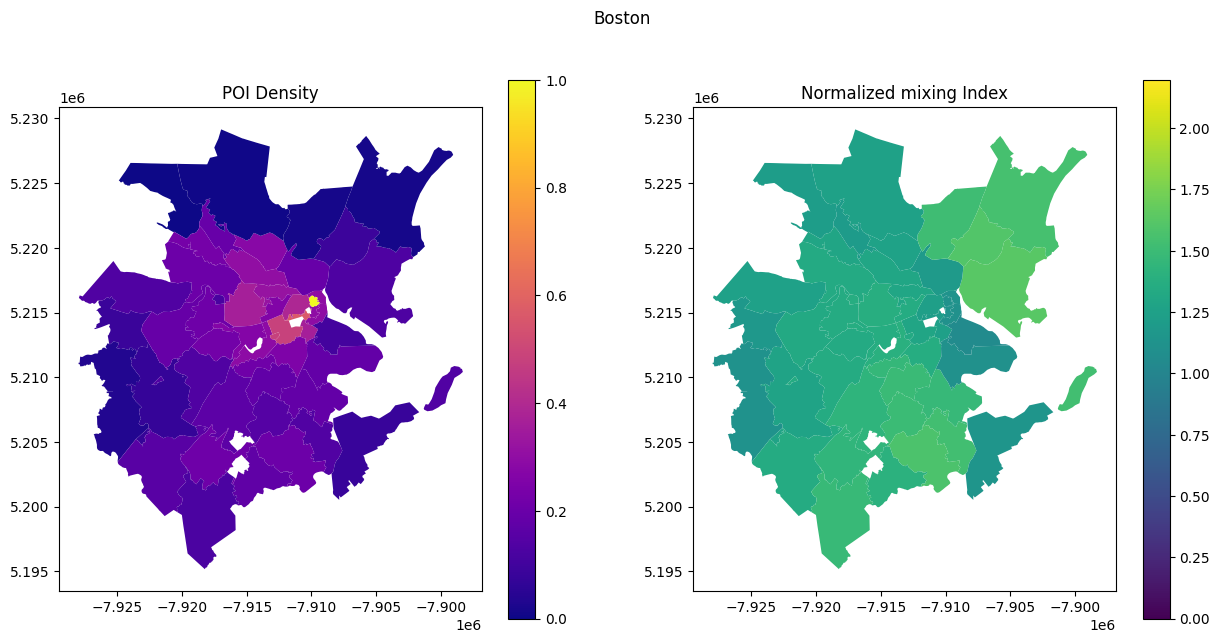

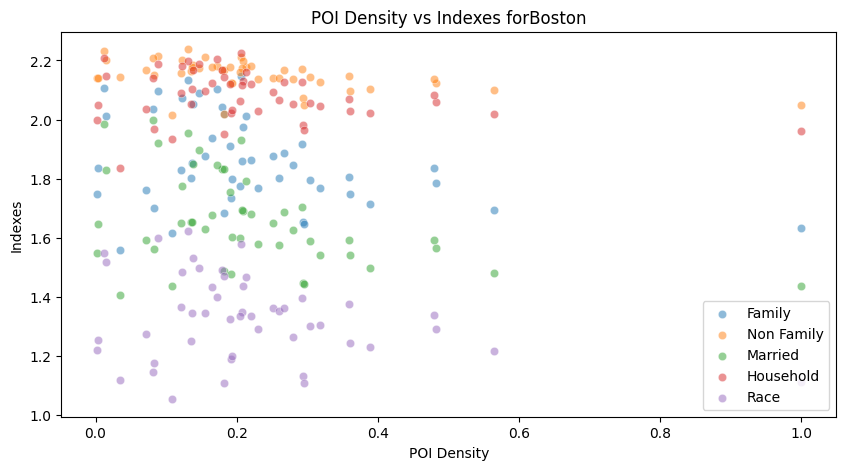

---- calculating the spatial correlation ----
Distance: 500 m
spatial pearson correlation:  -0.6504448092523317
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 750 m
spatial pearson correlation:  -0.6504448092523317
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 1000 m
spatial pearson correlation:  -0.797567352710359
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 1250 m
spatial pearson correlation:  -1.0058546579744743
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 1500 m
spatial pearson correlation:  -1.077628423485965
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 1750 m
spatial pearson correlation:  -0.9693586648403054
Regular Pearson Correlation: -0.26827242245840316 p-value: 0.06235624090937537


Distance: 2000 m
spatial pearson correlation:  -0.8299552074519988
Reg

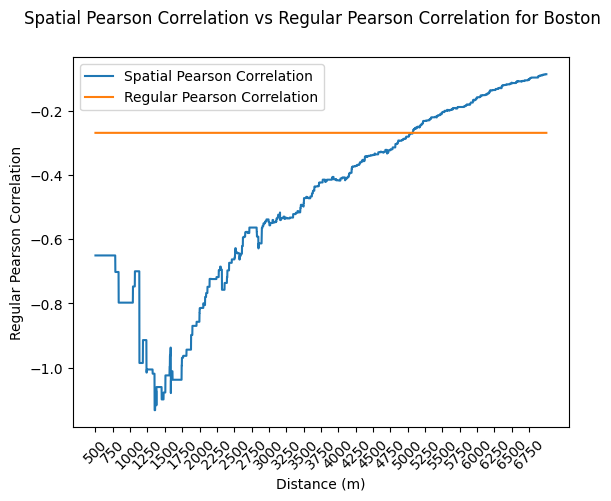

In [48]:
city = "Boston"
scc(city, zipcode_gdf)